In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
DATADIR = r'./combinado'
TRAIN_DIR = os.path.join(DATADIR, 'train')
TEST_DIR = os.path.join(DATADIR, 'test')
CATEGORIES = os.listdir(TRAIN_DIR)
print(CATEGORIES)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
def load_data(DATADIR, CATEGORIES):
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data
# Load training and testing data
train_data = load_data(TRAIN_DIR, CATEGORIES)
test_data = load_data(TEST_DIR, CATEGORIES)

100%|██████████| 851/851 [00:00<00:00, 4653.53it/s]


In [4]:
X_train = np.array([ x[0] for x in train_data])
y_train = np.array([Y[1] for Y in train_data])

X_test = np.array([ x[0] for x in test_data])
y_test = np.array([Y[1] for Y in test_data])

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29447, 48, 48), (29447,), (7367, 48, 48), (7367,))

In [14]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After reshaping
y_train shape:  (29447, 1)
y_test shape:  (7367, 1)
After adding color channel
X_train shape:  (29447, 48, 48, 1)
X_test shape:  (7367, 48, 48, 1)


In [15]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
y_train[0]

array([0])

In [17]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [19]:
y_train.shape, y_test.shape

((29447, 7), (7367, 7))

In [22]:
def Binarypatternnnnnnn(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values 
            img1_vector = np.delete(img1_vector,4)  
            digit = np.where(img1_vector)[0]         
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

In [23]:
import cv2
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)  
        Feature_data[i] = imgLBP
    
    return Feature_data

In [24]:
Feature_X_train = create_LBP_features(X_train)

In [25]:
Feature_X_train.shape

(29447, 48, 48, 1)

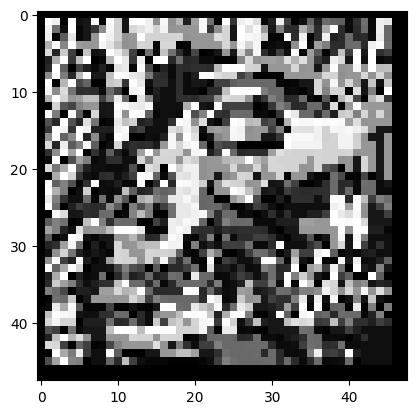

In [31]:
img = random.choice(Feature_X_train)
plt.imshow(img, cmap='gray')

In [32]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(7367, 48, 48, 1)

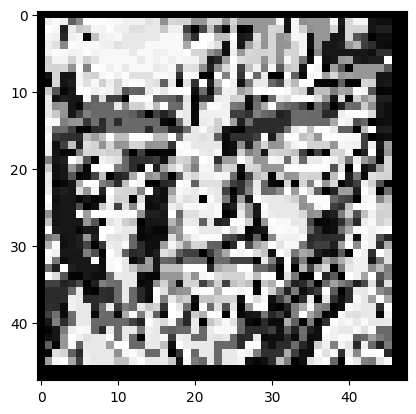

In [33]:
img = random.choice(Feature_X_test)
plt.imshow(img, cmap='gray')

In [34]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(CATEGORIES), activation='softmax'))

    return model


es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [35]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=50, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
3681/3681 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.2372 - loss: 3.0481 - val_accuracy: 0.2498 - val_loss: 1.8160 - learning_rate: 0.0010
Epoch 2/50
3681/3681 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.2481 - loss: 1.8026 - val_accuracy: 0.2962 - val_loss: 1.7432 - learning_rate: 0.0010
Epoch 3/50
3681/3681 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.2873 - loss: 1.7482 - val_accuracy: 0.3069 - val_loss: 1.7063 - learning_rate: 0.0010
Epoch 4/50
3681/3681 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.2844 - loss: 1.7333 - val_accuracy: 0.3076 - val_loss: 1.6957 - learning_rate: 0.0010
Epoch 5/50
3681/3681 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.2905 - loss: 1.7293 - val_accuracy: 0.3119 - val_loss: 1.6881 - learning_rate: 0.0010
Epoch 6/50
3681/3681 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.2966 - loss: 1.7078 - val_accuracy: 0.3161 - val_loss: 1.6766 - learning_rate: 0.0010
Epoch 7/50
3681/3681 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.3

In [37]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

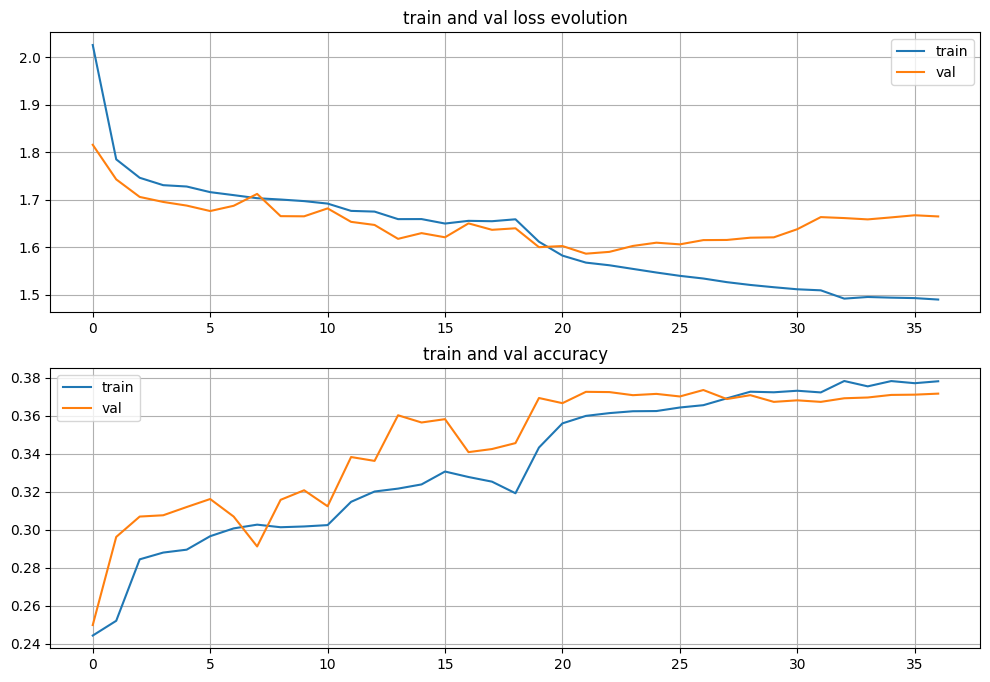

In [38]:
plot_performance(LBP_history)

In [39]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.3735577464103699


231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


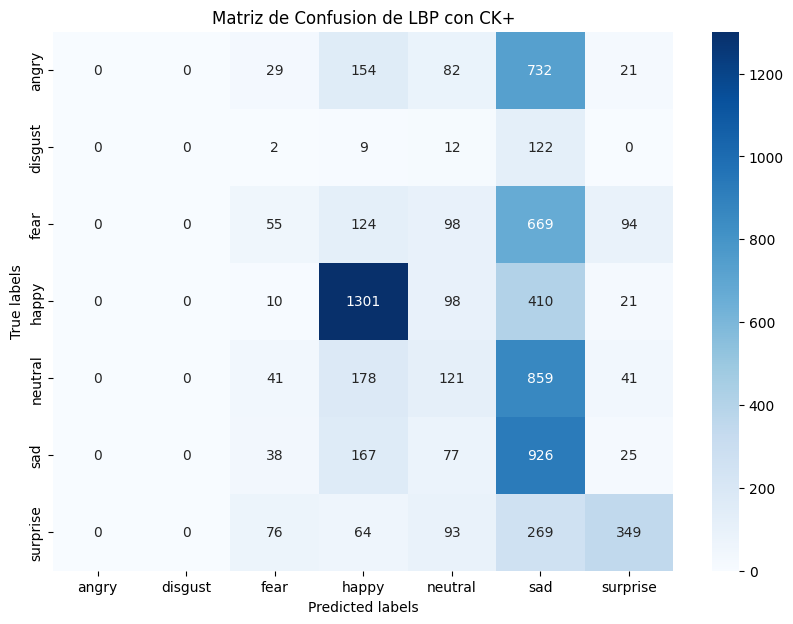

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcula la matriz de confusión y el reporte de clasificación
y_pred = np.argmax(LBP_model.predict(Feature_X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
conf_mat = confusion_matrix(y_true, y_pred)

# Crea un mapa de calor usando seaborn
plt.figure(figsize=(10, 7)) # Ajusta el tamaño de la figura
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)

# Añade títulos y etiquetas
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusion de LBP con CK+')
plt.show()

In [41]:
class_report = classification_report(y_true, y_pred, target_names=CATEGORIES)
print("\nClassification Report:\n", class_report)



Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1018
     disgust       0.00      0.00      0.00       145
        fear       0.22      0.05      0.09      1040
       happy       0.65      0.71      0.68      1840
     neutral       0.21      0.10      0.13      1240
         sad       0.23      0.75      0.35      1233
    surprise       0.63      0.41      0.50       851

    accuracy                           0.37      7367
   macro avg       0.28      0.29      0.25      7367
weighted avg       0.34      0.37      0.32      7367



c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [43]:
LBP_model.save('LBP_model_FER.keras')